# Segmentation of Medical Scans using Variational VAE's - Part 3/3
This series of notebooks enables reproduceability of our final models and testing results.

The third notebook goes through the process of creating, training and tuning a variational decoder, which will act as a segmenter.

We import some necessary libraries, and check if our GPU is available, while also retrieving some system stats. We need a lot of RAM, because our selected datasets are very large. We setup up some global constants.

In [1]:
# For ML
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
import torch.optim as optim
from torch import Tensor

# For displaying and evaluating results.
import numpy as np
from matplotlib import pyplot as plt

# For monitoring resource-usage and progress.
from timeit import default_timer as timer
import psutil
from os.path import join

# Our own utility functions, constants and classes.
from utility import CT_Dataset, superimpose, draw

# Our own DL models.
from models import VAEModel, SegmentationModel, Conv, ConvTranspose

# Paths.
root_dir = '../' # Relative to the working directory.
raw_data_dir = join(root_dir, 'raw_data')
prep_data_dir = join(root_dir, 'prep_data')
losses_dir = join(root_dir, 'losses')
models_dir = join(root_dir, 'saved_models')
checkpoint_dir = join(root_dir, 'checkpoints')


# Setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('CUDA version:', torch.version.cuda)

available_ram = round(psutil.virtual_memory()[0]/1000000000,2)
print('RAM: ' + str(available_ram) + 'GB')

c:\Users\dfels\anaconda3\envs\torch_environment\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda
NVIDIA GeForce RTX 2060 with Max-Q Design
CUDA version: 11.7
RAM: 33.74GB


We define a new function to create dataloaders - This time splitting the dataset into a training-, development- and testing-set.

In [2]:
def make_seg_loaders(data, batch_size):
    N = len(data); N_train = int(0.8*N); 
    N_dev = int((N - N_train)/2); N_test = int(N - N_train - N_dev)
    train_data, dev_data, test_data = D.random_split(data, [N_train, N_dev, N_test])
    train_loader = D.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    dev_loader = D.DataLoader(dev_data, batch_size=batch_size, shuffle=True)
    test_loader = D.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return train_loader, dev_loader, test_loader

Once again, we create an instance of the full dataset, and pass it the dataloader creator. Naturally, we use the same resolution and batch-size.

In [3]:
resolution = 2**8; batch_size = 32;
dataset = CT_Dataset(prep_data_dir, 'lung', resolution)
train_loader, dev_loader, test_loader = make_seg_loaders(dataset, batch_size)

This time, we simply use a binary-cross-entropy loss-function.

We also define a training-routine for a single epoch, i.e. a full round of training data, as well as an evaluation routine. These routines are different from the routines in the previous notebook.

In [77]:
loss_fn = nn.BCELoss(reduction='sum') # reduction='sum' to make tumors more important.

def train_epoch(vae_model, seg_model, optimizer, train_loader):
    seg_model.train()
    vae_model.eval()
    losses = 0
    
    for batch in train_loader:
        x = batch[0].to(device) # Batch of images.
        y = batch[1].to(device) # Batch of labels.
        optimizer.zero_grad()
        z = vae_model.forward_latent(x) # Get latent vector from VAE.
        y_hat = seg_model.forward(z) # Reconstruction from new decoder.
        loss = loss_fn(y_hat, y) # Compare reconstruction to label.
        loss.backward()
        optimizer.step()
        losses += loss.item()   
    
    return losses / len(train_loader)  # average loss

def evaluate(vae_model, seg_model, dev_loader):
    seg_model.eval()
    vae_model.eval()
    losses = 0

    for data in dev_loader:
        x = data[0].to(device)
        y = data[1].to(device)
        z = vae_model.forward_latent(x)
        y_hat = seg_model.forward(z)
        loss = loss_fn(y_hat, y)
        losses += loss.item() 
    return losses / len(dev_loader)

We load in our trained model, which we created in the previous notebook.

In [78]:
vae_model = torch.load(join(models_dir, 'vae_model.pt')).to(device)

We create an untrained instance of our `SegmentationModel` class, which we have defined in the `models.py` file. We specify an optimizer, as well as a learning rate scheduler. Again, we found that the `AdamW` optimizer, which is Adam with weight-decay, works slightly better than regular `Adam`. 

In [107]:
seg_model = SegmentationModel(base=16).to(device)

optimizer = optim.AdamW(seg_model.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.6)

a = vae_model.state_dict()
b = seg_model.state_dict()

for key in b:
    b[key] = a[key]
seg_model.load_state_dict(b)

<All keys matched successfully>

Training a single decoder is a lot faster than a full VAE, so we do not need checkpointing.

In [112]:
total_epochs = 50

#train_losses = []; dev_losses = []; lrs = []

try:
    for epoch in range(1, total_epochs+1):
        lrs.append(optimizer.param_groups[0]['lr'])
        start_time = timer()
        train_loss = train_epoch(vae_model, seg_model, optimizer, train_loader)
        train_losses.append(train_loss)
        end_time = timer()
        dev_loss = evaluate(vae_model, seg_model, dev_loader)
        dev_losses.append(dev_loss)
        scheduler.step()
        
        print((f"Epoch {epoch}:, Train-loss: {train_loss:.4f}, Dev-loss: {dev_loss:.4f}, "f"Epoch-time = {(end_time - start_time):.3f}s"))

    print('Training completed.')
    
except KeyboardInterrupt:
    print('Manually stopped.')

Epoch 1:, Train-loss: 463.7081, Dev-loss: 577.0502, Epoch-time = 58.189s
Epoch 2:, Train-loss: 463.0314, Dev-loss: 569.7976, Epoch-time = 58.552s
Epoch 3:, Train-loss: 447.0540, Dev-loss: 536.1280, Epoch-time = 58.894s
Epoch 4:, Train-loss: 463.6483, Dev-loss: 575.0859, Epoch-time = 58.982s
Epoch 5:, Train-loss: 447.7964, Dev-loss: 563.9321, Epoch-time = 59.070s
Epoch 6:, Train-loss: 455.6000, Dev-loss: 553.8924, Epoch-time = 59.143s
Epoch 7:, Train-loss: 445.1437, Dev-loss: 595.3459, Epoch-time = 59.249s
Epoch 8:, Train-loss: 453.2779, Dev-loss: 546.5738, Epoch-time = 59.034s
Epoch 9:, Train-loss: 455.5361, Dev-loss: 600.1134, Epoch-time = 59.028s
Epoch 10:, Train-loss: 456.6685, Dev-loss: 575.7604, Epoch-time = 59.053s
Epoch 11:, Train-loss: 459.5847, Dev-loss: 564.9786, Epoch-time = 59.026s
Epoch 12:, Train-loss: 442.9384, Dev-loss: 547.0142, Epoch-time = 59.025s
Manually stopped.


We save the trained segmentation model along with loss metrics.

In [111]:
#CAREFUL NOT TO OVERWRITE.
#torch.save(seg_model, join(models_dir, 'seg_model.pt')) 
#torch.save(train_losses, join(losses_dir, 'seg_train_losses.pt'))
#torch.save(dev_losses, join(losses_dir, 'seg_dev_losses.pt'))

In [113]:
seg_model = torch.load(join(models_dir, 'seg_model.pt')).to(device)
train_losses = torch.load(join(losses_dir, 'seg_train_losses.pt'))
dev_losses = torch.load(join(losses_dir, 'seg_dev_losses.pt'))

In [208]:
'''' Segmentation evaluation '''
eps = 1e-16
def IoU(label, recon, thresh):
    inter = ((label >= thresh) & (recon >= thresh)) * 1.0
    union = ((label >= thresh) | (recon >= thresh)) * 1.0
    return inter.sum() / (union.sum() + eps) / label.shape[0]

def seg_evaluate(vae_model, seg_model, loader):
    seg_model.eval()
    vae_model.eval()
    iou = 0
    no_labels = 0

    for data in loader:
        x = data[0].to(device)
        y = data[1].to(device)
        if y.sum() != 0: # Only evaluate if there is a tumor.
            z = vae_model.forward_latent(x)
            y_hat = seg_model.forward(z)
            iou += IoU(y, y_hat, 0.5)
            no_labels += 1
    return iou / no_labels # Average IoU

In [211]:
seg_evaluate(vae_model, seg_model, train_loader)

No tumor in this image.
No tumor in this image.
No tumor in this image.
No tumor in this image.
No tumor in this image.
No tumor in this image.
No tumor in this image.
No tumor in this image.
No tumor in this image.
No tumor in this image.
No tumor in this image.
No tumor in this image.
No tumor in this image.
No tumor in this image.
No tumor in this image.
No tumor in this image.
No tumor in this image.
No tumor in this image.
No tumor in this image.


tensor(0.0226, device='cuda:0')

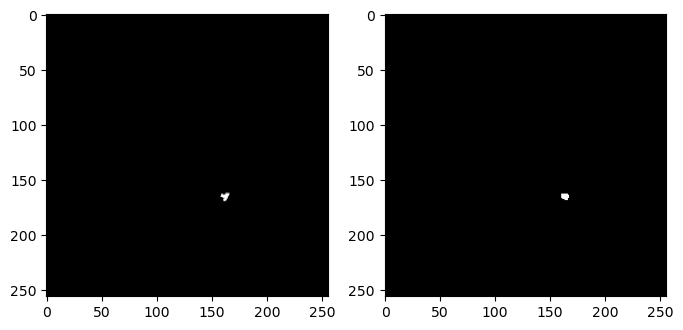

In [205]:
# Tell model to not update weights.
vae_model.eval()
seg_model.eval()

image, label = next(iter(dev_loader))

x = image[1][None, :].to(device) # Batch of 1 image.
y = label[1][None, :].to(device) # Batch of 1 label.

z = vae_model.forward_latent(x)
y_hat = seg_model.forward(z)

truth = torch.squeeze(y.cpu()).detach().numpy()
guess = (torch.squeeze(y_hat.cpu()).detach().numpy() > 0.5) * 1.0

fig, axs = plt.subplots(1, 2, figsize=(8,5))
axs[0].imshow(truth,cmap='gray')
axs[1].imshow(guess,cmap='gray')
fig.canvas.draw()